# Višeklasna klasifikacija

Ukoliko je broj klasa u zadatku klasifikacije veći od dva govorimo o višeklasnoj klasifikaciji. Za nju važe ista pravila pripreme podataka, kreiranja modela i evaluacije koja smo uveli u priči o binarnoj klasifikaciji. Binarni algoritmi klasifikacije se mogu uvek prilagoditi ovom viešklasnom scenariju kroz omotače `OneVsAll` i `OneVsOne` scikit-learn biblioteke, a neki od njih i kroz specifični parametar `multi_class`.  

Pretpostavimo da treba da naučimo da razlikujemo n=3 klasa. Obeležimo ih redom sa C1, C2 i C3.

`OneVsAll` (ili `oneVsRest`) pristup podrazumva učenje n binarnih klasifikatora koji mogu da razlikuju jednu uočenu klasu od preostalih klasa. Na primer, potrebno je naučiti klasifikator koji razdvaja klasu C1 od klasa C2 i C3, zatim klasifikator koji razdvaja klasu C2 od klasa C1 i C3, i na kraju, klasifikator koji razdvaja klase C3 od klasa C1 i C2. Kada je potrebno klasifikovati novu instancu, pokreće se svaki od naučenih klasifikatora i nad dobijenim rezultatima se primenjuje princip najveće pouzdanosti: instanca se pridružuje klasi za koju je klasifikator najsigurniji.

<img src='assets/OneVsRest.png'>

`OneVsOne` pristup podrazumeva učenje $\frac{n(n-1)}{2}$ binarnih klasifikatora sposobnih da razlikuju po dve klase. U našem primer, potrebno je naučiti binarne klasifikatore koji razdvajaju klase C1 i C2, C2 i C3, kao i C1 i C3. Kada je potrebno klasifikovati novu instancu, pokreće se svaki od naučenih klasifikatora i nad dobijenim rezultatima se primenjuje princip većinskog glasanja: instanca se pridružuje klasi za koju najveći broj klasifikatora glasa.

<img src='assets/OneVsOne.jpg'>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn import datasets
from sklearn import svm
from sklearn import multiclass
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
np.random.seed(7)

## Primer 1.

Ovaj primer približava rad sa višeklasnim klasifikatorima i omotačima `OneVsRest` i `OneVsOne`. 

Koristićemo sintetički generisane podatke generisane metodom `make_classification`. Generisaćemo 500 instaci sa po 2 atributa. Broj klasa koji ćemo posmatrati je 3. 

In [4]:
X, y = datasets.make_classification(n_samples=500, n_classes=3, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state = 20)

In [5]:
class_colors = ['orange', 'red', 'blue']

In [6]:
colors = [class_colors[c] for c in y]

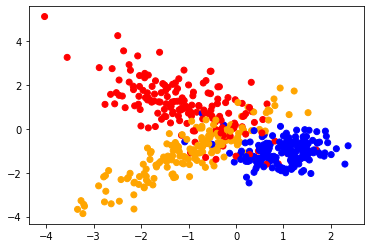

In [7]:
plt.scatter(X[:, 0],X[:, 1], color=colors)
plt.show()

Delimo podatke na skup za treniranje i skup za testiranje.

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, stratify = y)

Za kreiranje OneVsRest klasifikatora u čijoj osnovi je linarni SVC možemo koristiti metodu `multiclass.OneVsRestClassifier`. Slično važi i za OneVsOne klasifikator i `multiclass.OneVsOneClassifier` metodu. 

In [9]:
ovr_classifier = multiclass.OneVsRestClassifier(svm.LinearSVC())
ovo_classifier = multiclass.OneVsOneClassifier(svm.LinearSVC())

Treniramo modele.

In [10]:
ovr_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)

In [11]:
ovo_classifier.fit(X_train, y_train)

OneVsOneClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                       fit_intercept=True, intercept_scaling=1,
                                       loss='squared_hinge', max_iter=1000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   n_jobs=None)

Evaluiramo modele.

In [12]:
y_predicted_ovr = ovr_classifier.predict(X_test)

In [13]:
print(metrics.classification_report(y_test, y_predicted_ovr))

              precision    recall  f1-score   support

           0       0.90      0.65      0.75        54
           1       0.74      0.91      0.81        55
           2       0.95      0.98      0.96        56

    accuracy                           0.85       165
   macro avg       0.86      0.85      0.84       165
weighted avg       0.86      0.85      0.84       165



In [14]:
y_predicted_ovo = ovo_classifier.predict(X_test)

In [15]:
print(metrics.classification_report(y_test, y_predicted_ovo))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83        54
           1       0.85      0.84      0.84        55
           2       0.95      0.95      0.95        56

    accuracy                           0.87       165
   macro avg       0.87      0.87      0.87       165
weighted avg       0.87      0.87      0.87       165



Za evaluaciju modela korišćenjem tačnosti, preciznosti, odziva ili F1-mere mogu se koristiti funkcije `metrics` paketa uz dodatak parametra `avarage`. Njime se utiče na način izračunavanja metrika i dozvoljene su vrednosti `micro`, `macro` ili `weighted`. Na primer,  ukoliko se navede vrednost `micro`, vrednosti metrika se računaju globalno sumirajući sve TP, TN, FP i FP vrednosti pojedinačnih klasifikatora. Ukoliko se navede vrednost `macro` vrednosti metirka se izračunavaju pojedinačno za svaki klasifikator, a kao finalna ocena se uzima njihova aritmetička sredina. 

In [16]:
metrics.f1_score(y_test, y_predicted_ovo, average='macro')

0.872051114023591

## Primer 2.

Ovaj primer obrađuje problem identifikacije (prepoznavanja) jezika nekog teksta. Ova funkcionalnost je često integrisana u aplikacijama koje susrećemo, na primer, prilikom pretraživanja informacija potrebno je odrediti jezik upita, a prilikom predlaganja korekcija u tekstu, jezik dokumenta. U primeru ćemo koristiti fragmente teksta preuzete sa Vikipedije i podršku `scikit-learn` biblioteke za njihovu dalju obradu. Klasifikator `linearni SVM` ćemo ovog puta videti u ulozi višeklasnog klasifikatora. 

Za prevlačenje fragmenata teksta sa Vikipedije koristićemo skipt `fetch_data.py` koji je preuzet sa [zvanične strane](https://github.com/scikit-learn/scikit-learn/blob/master/doc/tutorial/text_analytics/data/languages/fetch_data.py) scikit-learn biblioteke. Njime će se u radnom direktorijumu kreirati tri direktorijuma, `html`, `paragraphs` i `short_paragraphs` sa tekstovima razvrstanim po jezicima (ukupno njih 11). Mi ćemo u daljem radu koristiti samo `paragraphs` direktorijum. 

Prevlačimo paragrafe.

In [17]:
!python scripts/fetch_data.py

Writing paragraphs/ar/ar_0000.txt
Writing short_paragraphs/ar/ar_0000.txt
Writing short_paragraphs/ar/ar_0001.txt
Writing short_paragraphs/ar/ar_0002.txt
Writing short_paragraphs/ar/ar_0003.txt
Writing short_paragraphs/ar/ar_0004.txt
Writing short_paragraphs/ar/ar_0005.txt
Writing short_paragraphs/ar/ar_0006.txt
Writing short_paragraphs/ar/ar_0007.txt
Writing short_paragraphs/ar/ar_0008.txt
Writing short_paragraphs/ar/ar_0009.txt
Writing short_paragraphs/ar/ar_0010.txt
Writing paragraphs/ar/ar_0001.txt
Writing short_paragraphs/ar/ar_0011.txt
Writing short_paragraphs/ar/ar_0012.txt
Writing short_paragraphs/ar/ar_0013.txt
Writing short_paragraphs/ar/ar_0014.txt
Writing short_paragraphs/ar/ar_0015.txt
Writing short_paragraphs/ar/ar_0016.txt
Writing short_paragraphs/ar/ar_0017.txt
Writing short_paragraphs/ar/ar_0018.txt
Writing short_paragraphs/ar/ar_0019.txt
Writing short_paragraphs/ar/ar_0020.txt
Writing short_paragraphs/ar/ar_0021.txt
Writing short_paragraphs/ar/ar_0022.txt
Writing shor

Writing short_paragraphs/ar/ar_0217.txt
Writing short_paragraphs/ar/ar_0218.txt
Writing short_paragraphs/ar/ar_0219.txt
Writing short_paragraphs/ar/ar_0220.txt
Writing short_paragraphs/ar/ar_0221.txt
Writing short_paragraphs/ar/ar_0222.txt
Writing short_paragraphs/ar/ar_0223.txt
Writing short_paragraphs/ar/ar_0224.txt
Writing short_paragraphs/ar/ar_0225.txt
Writing short_paragraphs/ar/ar_0226.txt
Writing short_paragraphs/ar/ar_0227.txt
Writing short_paragraphs/ar/ar_0228.txt
Writing paragraphs/ar/ar_0021.txt
Writing short_paragraphs/ar/ar_0229.txt
Writing short_paragraphs/ar/ar_0230.txt
Writing short_paragraphs/ar/ar_0231.txt
Writing short_paragraphs/ar/ar_0232.txt
Writing short_paragraphs/ar/ar_0233.txt
Writing paragraphs/ar/ar_0022.txt
Writing short_paragraphs/ar/ar_0234.txt
Writing short_paragraphs/ar/ar_0235.txt
Writing short_paragraphs/ar/ar_0236.txt
Writing short_paragraphs/ar/ar_0237.txt
Writing short_paragraphs/ar/ar_0238.txt
Writing short_paragraphs/ar/ar_0239.txt
Writing shor

Writing short_paragraphs/de/de_0193.txt
Writing short_paragraphs/de/de_0194.txt
Writing short_paragraphs/de/de_0195.txt
Writing paragraphs/de/de_0016.txt
Writing short_paragraphs/de/de_0196.txt
Writing short_paragraphs/de/de_0197.txt
Writing short_paragraphs/de/de_0198.txt
Writing short_paragraphs/de/de_0199.txt
Writing short_paragraphs/de/de_0200.txt
Writing short_paragraphs/de/de_0201.txt
Writing short_paragraphs/de/de_0202.txt
Writing paragraphs/de/de_0017.txt
Writing short_paragraphs/de/de_0203.txt
Writing short_paragraphs/de/de_0204.txt
Writing short_paragraphs/de/de_0205.txt
Writing short_paragraphs/de/de_0206.txt
Writing short_paragraphs/de/de_0207.txt
Writing short_paragraphs/de/de_0208.txt
Writing short_paragraphs/de/de_0209.txt
Writing short_paragraphs/de/de_0210.txt
Writing short_paragraphs/de/de_0211.txt
Writing short_paragraphs/de/de_0212.txt
Writing short_paragraphs/de/de_0213.txt
Writing short_paragraphs/de/de_0214.txt
Writing short_paragraphs/de/de_0215.txt
Writing shor

Writing short_paragraphs/de/de_0416.txt
Writing short_paragraphs/de/de_0417.txt
Writing short_paragraphs/de/de_0418.txt
Writing short_paragraphs/de/de_0419.txt
Writing short_paragraphs/de/de_0420.txt
Writing short_paragraphs/de/de_0421.txt
Writing short_paragraphs/de/de_0422.txt
Writing short_paragraphs/de/de_0423.txt
Writing short_paragraphs/de/de_0424.txt
Writing short_paragraphs/de/de_0425.txt
Writing short_paragraphs/de/de_0426.txt
Writing short_paragraphs/de/de_0427.txt
Writing short_paragraphs/de/de_0428.txt
Writing short_paragraphs/de/de_0429.txt
Writing paragraphs/de/de_0030.txt
Writing short_paragraphs/de/de_0430.txt
Writing short_paragraphs/de/de_0431.txt
Writing short_paragraphs/de/de_0432.txt
Writing short_paragraphs/de/de_0433.txt
Writing short_paragraphs/de/de_0434.txt
Writing short_paragraphs/de/de_0435.txt
Writing short_paragraphs/de/de_0436.txt
Writing short_paragraphs/de/de_0437.txt
Writing short_paragraphs/de/de_0438.txt
Writing short_paragraphs/de/de_0439.txt
Writin

Writing short_paragraphs/de/de_0637.txt
Writing short_paragraphs/de/de_0638.txt
Writing short_paragraphs/de/de_0639.txt
Writing short_paragraphs/de/de_0640.txt
Writing short_paragraphs/de/de_0641.txt
Writing short_paragraphs/de/de_0642.txt
Writing short_paragraphs/de/de_0643.txt
Writing short_paragraphs/de/de_0644.txt
Writing short_paragraphs/de/de_0645.txt
Writing short_paragraphs/de/de_0646.txt
Writing short_paragraphs/de/de_0647.txt
Writing short_paragraphs/de/de_0648.txt
Writing short_paragraphs/de/de_0649.txt
Writing short_paragraphs/de/de_0650.txt
Writing short_paragraphs/de/de_0651.txt
Writing paragraphs/de/de_0051.txt
Writing short_paragraphs/de/de_0652.txt
Writing short_paragraphs/de/de_0653.txt
Writing short_paragraphs/de/de_0654.txt
Writing short_paragraphs/de/de_0655.txt
Writing short_paragraphs/de/de_0656.txt
Writing short_paragraphs/de/de_0657.txt
Writing short_paragraphs/de/de_0658.txt
Writing short_paragraphs/de/de_0659.txt
Writing short_paragraphs/de/de_0660.txt
Writin

Writing short_paragraphs/de/de_0882.txt
Writing short_paragraphs/de/de_0883.txt
Writing short_paragraphs/de/de_0884.txt
Writing short_paragraphs/de/de_0885.txt
Writing short_paragraphs/de/de_0886.txt
Writing short_paragraphs/de/de_0887.txt
Writing short_paragraphs/de/de_0888.txt
Writing short_paragraphs/de/de_0889.txt
Writing short_paragraphs/de/de_0890.txt
Writing short_paragraphs/de/de_0891.txt
Writing short_paragraphs/de/de_0892.txt
Writing short_paragraphs/de/de_0893.txt
Writing short_paragraphs/de/de_0894.txt
Writing paragraphs/de/de_0070.txt
Writing short_paragraphs/de/de_0895.txt
Writing short_paragraphs/de/de_0896.txt
Writing short_paragraphs/de/de_0897.txt
Writing short_paragraphs/de/de_0898.txt
Writing short_paragraphs/de/de_0899.txt
Writing short_paragraphs/de/de_0900.txt
Writing short_paragraphs/de/de_0901.txt
Writing short_paragraphs/de/de_0902.txt
Writing short_paragraphs/de/de_0903.txt
Writing short_paragraphs/de/de_0904.txt
Writing short_paragraphs/de/de_0905.txt
Writin

Writing paragraphs/de/de_0143.txt
Writing short_paragraphs/de/de_1064.txt
Writing paragraphs/de/de_0144.txt
Writing short_paragraphs/de/de_1065.txt
Writing paragraphs/de/de_0145.txt
Writing short_paragraphs/de/de_1066.txt
Writing paragraphs/de/de_0146.txt
Writing short_paragraphs/de/de_1067.txt
Writing paragraphs/de/de_0147.txt
Writing short_paragraphs/de/de_1068.txt
Writing paragraphs/de/de_0148.txt
Writing short_paragraphs/de/de_1069.txt
Writing paragraphs/de/de_0149.txt
Writing short_paragraphs/de/de_1070.txt
Writing paragraphs/de/de_0150.txt
Writing short_paragraphs/de/de_1071.txt
Writing paragraphs/de/de_0151.txt
Writing short_paragraphs/de/de_1072.txt
Writing paragraphs/de/de_0152.txt
Writing short_paragraphs/de/de_1073.txt
Writing paragraphs/de/de_0153.txt
Writing short_paragraphs/de/de_1074.txt
Writing paragraphs/de/de_0154.txt
Writing short_paragraphs/de/de_1075.txt
Writing paragraphs/de/de_0155.txt
Writing short_paragraphs/de/de_1076.txt
Writing paragraphs/de/de_0156.txt
Writ

Writing short_paragraphs/en/en_0210.txt
Writing short_paragraphs/en/en_0211.txt
Writing short_paragraphs/en/en_0212.txt
Writing short_paragraphs/en/en_0213.txt
Writing short_paragraphs/en/en_0214.txt
Writing short_paragraphs/en/en_0215.txt
Writing short_paragraphs/en/en_0216.txt
Writing short_paragraphs/en/en_0217.txt
Writing short_paragraphs/en/en_0218.txt
Writing short_paragraphs/en/en_0219.txt
Writing short_paragraphs/en/en_0220.txt
Writing short_paragraphs/en/en_0221.txt
Writing short_paragraphs/en/en_0222.txt
Writing short_paragraphs/en/en_0223.txt
Writing short_paragraphs/en/en_0224.txt
Writing paragraphs/en/en_0011.txt
Writing short_paragraphs/en/en_0225.txt
Writing short_paragraphs/en/en_0226.txt
Writing short_paragraphs/en/en_0227.txt
Writing short_paragraphs/en/en_0228.txt
Writing short_paragraphs/en/en_0229.txt
Writing short_paragraphs/en/en_0230.txt
Writing short_paragraphs/en/en_0231.txt
Writing short_paragraphs/en/en_0232.txt
Writing short_paragraphs/en/en_0233.txt
Writin

Writing short_paragraphs/en/en_0445.txt
Writing short_paragraphs/en/en_0446.txt
Writing short_paragraphs/en/en_0447.txt
Writing short_paragraphs/en/en_0448.txt
Writing short_paragraphs/en/en_0449.txt
Writing short_paragraphs/en/en_0450.txt
Writing short_paragraphs/en/en_0451.txt
Writing short_paragraphs/en/en_0452.txt
Writing short_paragraphs/en/en_0453.txt
Writing short_paragraphs/en/en_0454.txt
Writing short_paragraphs/en/en_0455.txt
Writing short_paragraphs/en/en_0456.txt
Writing short_paragraphs/en/en_0457.txt
Writing short_paragraphs/en/en_0458.txt
Writing short_paragraphs/en/en_0459.txt
Writing short_paragraphs/en/en_0460.txt
Writing short_paragraphs/en/en_0461.txt
Writing short_paragraphs/en/en_0462.txt
Writing paragraphs/en/en_0028.txt
Writing short_paragraphs/en/en_0463.txt
Writing short_paragraphs/en/en_0464.txt
Writing short_paragraphs/en/en_0465.txt
Writing short_paragraphs/en/en_0466.txt
Writing short_paragraphs/en/en_0467.txt
Writing short_paragraphs/en/en_0468.txt
Writin

Writing short_paragraphs/en/en_0686.txt
Writing short_paragraphs/en/en_0687.txt
Writing short_paragraphs/en/en_0688.txt
Writing short_paragraphs/en/en_0689.txt
Writing paragraphs/en/en_0042.txt
Writing short_paragraphs/en/en_0690.txt
Writing short_paragraphs/en/en_0691.txt
Writing short_paragraphs/en/en_0692.txt
Writing short_paragraphs/en/en_0693.txt
Writing short_paragraphs/en/en_0694.txt
Writing short_paragraphs/en/en_0695.txt
Writing short_paragraphs/en/en_0696.txt
Writing short_paragraphs/en/en_0697.txt
Writing short_paragraphs/en/en_0698.txt
Writing short_paragraphs/en/en_0699.txt
Writing short_paragraphs/en/en_0700.txt
Writing short_paragraphs/en/en_0701.txt
Writing short_paragraphs/en/en_0702.txt
Writing short_paragraphs/en/en_0703.txt
Writing short_paragraphs/en/en_0704.txt
Writing short_paragraphs/en/en_0705.txt
Writing short_paragraphs/en/en_0706.txt
Writing short_paragraphs/en/en_0707.txt
Writing short_paragraphs/en/en_0708.txt
Writing short_paragraphs/en/en_0709.txt
Writin

Writing paragraphs/en/en_0055.txt
Writing short_paragraphs/en/en_0902.txt
Writing short_paragraphs/en/en_0903.txt
Writing short_paragraphs/en/en_0904.txt
Writing paragraphs/en/en_0056.txt
Writing short_paragraphs/en/en_0905.txt
Writing short_paragraphs/en/en_0906.txt
Writing short_paragraphs/en/en_0907.txt
Writing short_paragraphs/en/en_0908.txt
Writing short_paragraphs/en/en_0909.txt
Writing short_paragraphs/en/en_0910.txt
Writing short_paragraphs/en/en_0911.txt
Writing short_paragraphs/en/en_0912.txt
Writing short_paragraphs/en/en_0913.txt
Writing short_paragraphs/en/en_0914.txt
Writing short_paragraphs/en/en_0915.txt
Writing short_paragraphs/en/en_0916.txt
Writing short_paragraphs/en/en_0917.txt
Writing short_paragraphs/en/en_0918.txt
Writing short_paragraphs/en/en_0919.txt
Writing short_paragraphs/en/en_0920.txt
Writing short_paragraphs/en/en_0921.txt
Writing short_paragraphs/en/en_0922.txt
Writing short_paragraphs/en/en_0923.txt
Writing short_paragraphs/en/en_0924.txt
Writing shor

Writing paragraphs/en/en_0118.txt
Writing short_paragraphs/en/en_1057.txt
Writing paragraphs/en/en_0119.txt
Writing short_paragraphs/en/en_1058.txt
Writing paragraphs/en/en_0120.txt
Writing short_paragraphs/en/en_1059.txt
Writing paragraphs/en/en_0121.txt
Writing short_paragraphs/en/en_1060.txt
Writing paragraphs/en/en_0122.txt
Writing short_paragraphs/en/en_1061.txt
Writing paragraphs/en/en_0123.txt
Writing short_paragraphs/en/en_1062.txt
Writing paragraphs/en/en_0124.txt
Writing short_paragraphs/en/en_1063.txt
Writing paragraphs/en/en_0125.txt
Writing short_paragraphs/en/en_1064.txt
Writing paragraphs/en/en_0126.txt
Writing short_paragraphs/en/en_1065.txt
Writing paragraphs/en/en_0127.txt
Writing short_paragraphs/en/en_1066.txt
Writing paragraphs/en/en_0128.txt
Writing short_paragraphs/en/en_1067.txt
Writing paragraphs/en/en_0129.txt
Writing short_paragraphs/en/en_1068.txt
Writing paragraphs/en/en_0130.txt
Writing short_paragraphs/en/en_1069.txt
Writing paragraphs/en/en_0131.txt
Writ

Writing short_paragraphs/es/es_0141.txt
Writing short_paragraphs/es/es_0142.txt
Writing short_paragraphs/es/es_0143.txt
Writing short_paragraphs/es/es_0144.txt
Writing short_paragraphs/es/es_0145.txt
Writing short_paragraphs/es/es_0146.txt
Writing short_paragraphs/es/es_0147.txt
Writing short_paragraphs/es/es_0148.txt
Writing short_paragraphs/es/es_0149.txt
Writing paragraphs/es/es_0013.txt
Writing short_paragraphs/es/es_0150.txt
Writing short_paragraphs/es/es_0151.txt
Writing short_paragraphs/es/es_0152.txt
Writing short_paragraphs/es/es_0153.txt
Writing short_paragraphs/es/es_0154.txt
Writing short_paragraphs/es/es_0155.txt
Writing short_paragraphs/es/es_0156.txt
Writing short_paragraphs/es/es_0157.txt
Writing paragraphs/es/es_0014.txt
Writing short_paragraphs/es/es_0158.txt
Writing short_paragraphs/es/es_0159.txt
Writing short_paragraphs/es/es_0160.txt
Writing short_paragraphs/es/es_0161.txt
Writing short_paragraphs/es/es_0162.txt
Writing short_paragraphs/es/es_0163.txt
Writing para

Writing short_paragraphs/es/es_0363.txt
Writing short_paragraphs/es/es_0364.txt
Writing short_paragraphs/es/es_0365.txt
Writing short_paragraphs/es/es_0366.txt
Writing short_paragraphs/es/es_0367.txt
Writing short_paragraphs/es/es_0368.txt
Writing short_paragraphs/es/es_0369.txt
Writing short_paragraphs/es/es_0370.txt
Writing short_paragraphs/es/es_0371.txt
Writing short_paragraphs/es/es_0372.txt
Writing short_paragraphs/es/es_0373.txt
Writing short_paragraphs/es/es_0374.txt
Writing short_paragraphs/es/es_0375.txt
Writing short_paragraphs/es/es_0376.txt
Writing short_paragraphs/es/es_0377.txt
Writing short_paragraphs/es/es_0378.txt
Writing short_paragraphs/es/es_0379.txt
Writing short_paragraphs/es/es_0380.txt
Writing short_paragraphs/es/es_0381.txt
Writing short_paragraphs/es/es_0382.txt
Writing short_paragraphs/es/es_0383.txt
Writing short_paragraphs/es/es_0384.txt
Writing short_paragraphs/es/es_0385.txt
Writing short_paragraphs/es/es_0386.txt
Writing short_paragraphs/es/es_0387.txt


Writing short_paragraphs/es/es_0601.txt
Writing short_paragraphs/es/es_0602.txt
Writing short_paragraphs/es/es_0603.txt
Writing short_paragraphs/es/es_0604.txt
Writing short_paragraphs/es/es_0605.txt
Writing short_paragraphs/es/es_0606.txt
Writing short_paragraphs/es/es_0607.txt
Writing short_paragraphs/es/es_0608.txt
Writing short_paragraphs/es/es_0609.txt
Writing short_paragraphs/es/es_0610.txt
Writing short_paragraphs/es/es_0611.txt
Writing short_paragraphs/es/es_0612.txt
Writing short_paragraphs/es/es_0613.txt
Writing short_paragraphs/es/es_0614.txt
Writing short_paragraphs/es/es_0615.txt
Writing paragraphs/es/es_0042.txt
Writing short_paragraphs/es/es_0616.txt
Writing short_paragraphs/es/es_0617.txt
Writing short_paragraphs/es/es_0618.txt
Writing short_paragraphs/es/es_0619.txt
Writing short_paragraphs/es/es_0620.txt
Writing short_paragraphs/es/es_0621.txt
Writing short_paragraphs/es/es_0622.txt
Writing short_paragraphs/es/es_0623.txt
Writing short_paragraphs/es/es_0624.txt
Writin

Writing short_paragraphs/es/es_0848.txt
Writing short_paragraphs/es/es_0849.txt
Writing short_paragraphs/es/es_0850.txt
Writing short_paragraphs/es/es_0851.txt
Writing short_paragraphs/es/es_0852.txt
Writing short_paragraphs/es/es_0853.txt
Writing short_paragraphs/es/es_0854.txt
Writing short_paragraphs/es/es_0855.txt
Writing short_paragraphs/es/es_0856.txt
Writing short_paragraphs/es/es_0857.txt
Writing short_paragraphs/es/es_0858.txt
Writing short_paragraphs/es/es_0859.txt
Writing short_paragraphs/es/es_0860.txt
Writing short_paragraphs/es/es_0861.txt
Writing paragraphs/es/es_0058.txt
Writing short_paragraphs/es/es_0862.txt
Writing short_paragraphs/es/es_0863.txt
Writing short_paragraphs/es/es_0864.txt
Writing short_paragraphs/es/es_0865.txt
Writing short_paragraphs/es/es_0866.txt
Writing short_paragraphs/es/es_0867.txt
Writing short_paragraphs/es/es_0868.txt
Writing short_paragraphs/es/es_0869.txt
Writing short_paragraphs/es/es_0870.txt
Writing short_paragraphs/es/es_0871.txt
Writin

Writing paragraphs/es/es_0113.txt
Writing short_paragraphs/es/es_1047.txt
Writing paragraphs/es/es_0114.txt
Writing short_paragraphs/es/es_1048.txt
Writing paragraphs/fr/fr_0000.txt
Writing short_paragraphs/fr/fr_0000.txt
Writing short_paragraphs/fr/fr_0001.txt
Writing short_paragraphs/fr/fr_0002.txt
Writing short_paragraphs/fr/fr_0003.txt
Writing short_paragraphs/fr/fr_0004.txt
Writing short_paragraphs/fr/fr_0005.txt
Writing short_paragraphs/fr/fr_0006.txt
Writing short_paragraphs/fr/fr_0007.txt
Writing short_paragraphs/fr/fr_0008.txt
Writing short_paragraphs/fr/fr_0009.txt
Writing short_paragraphs/fr/fr_0010.txt
Writing short_paragraphs/fr/fr_0011.txt
Writing short_paragraphs/fr/fr_0012.txt
Writing paragraphs/fr/fr_0001.txt
Writing short_paragraphs/fr/fr_0013.txt
Writing short_paragraphs/fr/fr_0014.txt
Writing short_paragraphs/fr/fr_0015.txt
Writing short_paragraphs/fr/fr_0016.txt
Writing short_paragraphs/fr/fr_0017.txt
Writing paragraphs/fr/fr_0002.txt
Writing short_paragraphs/fr/fr

Writing short_paragraphs/fr/fr_0217.txt
Writing short_paragraphs/fr/fr_0218.txt
Writing short_paragraphs/fr/fr_0219.txt
Writing paragraphs/fr/fr_0015.txt
Writing short_paragraphs/fr/fr_0220.txt
Writing short_paragraphs/fr/fr_0221.txt
Writing short_paragraphs/fr/fr_0222.txt
Writing short_paragraphs/fr/fr_0223.txt
Writing short_paragraphs/fr/fr_0224.txt
Writing short_paragraphs/fr/fr_0225.txt
Writing short_paragraphs/fr/fr_0226.txt
Writing short_paragraphs/fr/fr_0227.txt
Writing short_paragraphs/fr/fr_0228.txt
Writing short_paragraphs/fr/fr_0229.txt
Writing short_paragraphs/fr/fr_0230.txt
Writing short_paragraphs/fr/fr_0231.txt
Writing short_paragraphs/fr/fr_0232.txt
Writing short_paragraphs/fr/fr_0233.txt
Writing short_paragraphs/fr/fr_0234.txt
Writing short_paragraphs/fr/fr_0235.txt
Writing short_paragraphs/fr/fr_0236.txt
Writing short_paragraphs/fr/fr_0237.txt
Writing short_paragraphs/fr/fr_0238.txt
Writing short_paragraphs/fr/fr_0239.txt
Writing short_paragraphs/fr/fr_0240.txt
Writin

Writing short_paragraphs/fr/fr_0448.txt
Writing short_paragraphs/fr/fr_0449.txt
Writing short_paragraphs/fr/fr_0450.txt
Writing short_paragraphs/fr/fr_0451.txt
Writing short_paragraphs/fr/fr_0452.txt
Writing short_paragraphs/fr/fr_0453.txt
Writing short_paragraphs/fr/fr_0454.txt
Writing short_paragraphs/fr/fr_0455.txt
Writing short_paragraphs/fr/fr_0456.txt
Writing short_paragraphs/fr/fr_0457.txt
Writing paragraphs/fr/fr_0031.txt
Writing short_paragraphs/fr/fr_0458.txt
Writing short_paragraphs/fr/fr_0459.txt
Writing short_paragraphs/fr/fr_0460.txt
Writing paragraphs/fr/fr_0032.txt
Writing short_paragraphs/fr/fr_0461.txt
Writing short_paragraphs/fr/fr_0462.txt
Writing short_paragraphs/fr/fr_0463.txt
Writing short_paragraphs/fr/fr_0464.txt
Writing short_paragraphs/fr/fr_0465.txt
Writing short_paragraphs/fr/fr_0466.txt
Writing short_paragraphs/fr/fr_0467.txt
Writing short_paragraphs/fr/fr_0468.txt
Writing short_paragraphs/fr/fr_0469.txt
Writing short_paragraphs/fr/fr_0470.txt
Writing shor

Writing short_paragraphs/fr/fr_0654.txt
Writing short_paragraphs/fr/fr_0655.txt
Writing short_paragraphs/fr/fr_0656.txt
Writing short_paragraphs/fr/fr_0657.txt
Writing short_paragraphs/fr/fr_0658.txt
Writing short_paragraphs/fr/fr_0659.txt
Writing short_paragraphs/fr/fr_0660.txt
Writing short_paragraphs/fr/fr_0661.txt
Writing short_paragraphs/fr/fr_0662.txt
Writing short_paragraphs/fr/fr_0663.txt
Writing short_paragraphs/fr/fr_0664.txt
Writing short_paragraphs/fr/fr_0665.txt
Writing short_paragraphs/fr/fr_0666.txt
Writing short_paragraphs/fr/fr_0667.txt
Writing short_paragraphs/fr/fr_0668.txt
Writing short_paragraphs/fr/fr_0669.txt
Writing short_paragraphs/fr/fr_0670.txt
Writing short_paragraphs/fr/fr_0671.txt
Writing short_paragraphs/fr/fr_0672.txt
Writing short_paragraphs/fr/fr_0673.txt
Writing short_paragraphs/fr/fr_0674.txt
Writing short_paragraphs/fr/fr_0675.txt
Writing paragraphs/fr/fr_0048.txt
Writing short_paragraphs/fr/fr_0676.txt
Writing short_paragraphs/fr/fr_0677.txt
Writin

Writing short_paragraphs/fr/fr_0852.txt
Writing short_paragraphs/fr/fr_0853.txt
Writing short_paragraphs/fr/fr_0854.txt
Writing short_paragraphs/fr/fr_0855.txt
Writing short_paragraphs/fr/fr_0856.txt
Writing short_paragraphs/fr/fr_0857.txt
Writing short_paragraphs/fr/fr_0858.txt
Writing short_paragraphs/fr/fr_0859.txt
Writing short_paragraphs/fr/fr_0860.txt
Writing short_paragraphs/fr/fr_0861.txt
Writing short_paragraphs/fr/fr_0862.txt
Writing short_paragraphs/fr/fr_0863.txt
Writing short_paragraphs/fr/fr_0864.txt
Writing short_paragraphs/fr/fr_0865.txt
Writing short_paragraphs/fr/fr_0866.txt
Writing short_paragraphs/fr/fr_0867.txt
Writing short_paragraphs/fr/fr_0868.txt
Writing short_paragraphs/fr/fr_0869.txt
Writing short_paragraphs/fr/fr_0870.txt
Writing short_paragraphs/fr/fr_0871.txt
Writing short_paragraphs/fr/fr_0872.txt
Writing short_paragraphs/fr/fr_0873.txt
Writing paragraphs/fr/fr_0066.txt
Writing short_paragraphs/fr/fr_0874.txt
Writing short_paragraphs/fr/fr_0875.txt
Writin

Writing paragraphs/fr/fr_0109.txt
Writing short_paragraphs/fr/fr_1034.txt
Writing paragraphs/fr/fr_0110.txt
Writing short_paragraphs/fr/fr_1035.txt
Writing paragraphs/fr/fr_0111.txt
Writing short_paragraphs/fr/fr_1036.txt
Writing paragraphs/fr/fr_0112.txt
Writing short_paragraphs/fr/fr_1037.txt
Writing paragraphs/fr/fr_0113.txt
Writing short_paragraphs/fr/fr_1038.txt
Writing paragraphs/fr/fr_0114.txt
Writing short_paragraphs/fr/fr_1039.txt
Writing paragraphs/fr/fr_0115.txt
Writing short_paragraphs/fr/fr_1040.txt
Writing paragraphs/fr/fr_0116.txt
Writing short_paragraphs/fr/fr_1041.txt
Writing paragraphs/fr/fr_0117.txt
Writing short_paragraphs/fr/fr_1042.txt
Writing paragraphs/fr/fr_0118.txt
Writing short_paragraphs/fr/fr_1043.txt
Writing paragraphs/fr/fr_0119.txt
Writing short_paragraphs/fr/fr_1044.txt
Writing paragraphs/fr/fr_0120.txt
Writing short_paragraphs/fr/fr_1045.txt
Writing paragraphs/fr/fr_0121.txt
Writing short_paragraphs/fr/fr_1046.txt
Writing paragraphs/fr/fr_0122.txt
Writ

Writing short_paragraphs/it/it_0222.txt
Writing short_paragraphs/it/it_0223.txt
Writing short_paragraphs/it/it_0224.txt
Writing short_paragraphs/it/it_0225.txt
Writing short_paragraphs/it/it_0226.txt
Writing short_paragraphs/it/it_0227.txt
Writing short_paragraphs/it/it_0228.txt
Writing short_paragraphs/it/it_0229.txt
Writing short_paragraphs/it/it_0230.txt
Writing short_paragraphs/it/it_0231.txt
Writing short_paragraphs/it/it_0232.txt
Writing short_paragraphs/it/it_0233.txt
Writing paragraphs/it/it_0017.txt
Writing short_paragraphs/it/it_0234.txt
Writing short_paragraphs/it/it_0235.txt
Writing short_paragraphs/it/it_0236.txt
Writing short_paragraphs/it/it_0237.txt
Writing short_paragraphs/it/it_0238.txt
Writing short_paragraphs/it/it_0239.txt
Writing short_paragraphs/it/it_0240.txt
Writing short_paragraphs/it/it_0241.txt
Writing short_paragraphs/it/it_0242.txt
Writing short_paragraphs/it/it_0243.txt
Writing short_paragraphs/it/it_0244.txt
Writing short_paragraphs/it/it_0245.txt
Writin

Writing short_paragraphs/it/it_0500.txt
Writing short_paragraphs/it/it_0501.txt
Writing short_paragraphs/it/it_0502.txt
Writing short_paragraphs/it/it_0503.txt
Writing short_paragraphs/it/it_0504.txt
Writing short_paragraphs/it/it_0505.txt
Writing short_paragraphs/it/it_0506.txt
Writing short_paragraphs/it/it_0507.txt
Writing short_paragraphs/it/it_0508.txt
Writing short_paragraphs/it/it_0509.txt
Writing short_paragraphs/it/it_0510.txt
Writing short_paragraphs/it/it_0511.txt
Writing short_paragraphs/it/it_0512.txt
Writing short_paragraphs/it/it_0513.txt
Writing short_paragraphs/it/it_0514.txt
Writing short_paragraphs/it/it_0515.txt
Writing short_paragraphs/it/it_0516.txt
Writing short_paragraphs/it/it_0517.txt
Writing short_paragraphs/it/it_0518.txt
Writing short_paragraphs/it/it_0519.txt
Writing short_paragraphs/it/it_0520.txt
Writing short_paragraphs/it/it_0521.txt
Writing short_paragraphs/it/it_0522.txt
Writing short_paragraphs/it/it_0523.txt
Writing short_paragraphs/it/it_0524.txt


Writing short_paragraphs/it/it_0723.txt
Writing short_paragraphs/it/it_0724.txt
Writing short_paragraphs/it/it_0725.txt
Writing short_paragraphs/it/it_0726.txt
Writing short_paragraphs/it/it_0727.txt
Writing paragraphs/it/it_0046.txt
Writing short_paragraphs/it/it_0728.txt
Writing short_paragraphs/it/it_0729.txt
Writing short_paragraphs/it/it_0730.txt
Writing short_paragraphs/it/it_0731.txt
Writing short_paragraphs/it/it_0732.txt
Writing short_paragraphs/it/it_0733.txt
Writing short_paragraphs/it/it_0734.txt
Writing short_paragraphs/it/it_0735.txt
Writing short_paragraphs/it/it_0736.txt
Writing short_paragraphs/it/it_0737.txt
Writing short_paragraphs/it/it_0738.txt
Writing short_paragraphs/it/it_0739.txt
Writing short_paragraphs/it/it_0740.txt
Writing short_paragraphs/it/it_0741.txt
Writing short_paragraphs/it/it_0742.txt
Writing short_paragraphs/it/it_0743.txt
Writing short_paragraphs/it/it_0744.txt
Writing short_paragraphs/it/it_0745.txt
Writing short_paragraphs/it/it_0746.txt
Writin

Writing short_paragraphs/it/it_0959.txt
Writing short_paragraphs/it/it_0960.txt
Writing short_paragraphs/it/it_0961.txt
Writing short_paragraphs/it/it_0962.txt
Writing short_paragraphs/it/it_0963.txt
Writing short_paragraphs/it/it_0964.txt
Writing short_paragraphs/it/it_0965.txt
Writing short_paragraphs/it/it_0966.txt
Writing short_paragraphs/it/it_0967.txt
Writing short_paragraphs/it/it_0968.txt
Writing short_paragraphs/it/it_0969.txt
Writing short_paragraphs/it/it_0970.txt
Writing paragraphs/it/it_0060.txt
Writing short_paragraphs/it/it_0971.txt
Writing short_paragraphs/it/it_0972.txt
Writing short_paragraphs/it/it_0973.txt
Writing short_paragraphs/it/it_0974.txt
Writing short_paragraphs/it/it_0975.txt
Writing short_paragraphs/it/it_0976.txt
Writing short_paragraphs/it/it_0977.txt
Writing short_paragraphs/it/it_0978.txt
Writing paragraphs/it/it_0061.txt
Writing short_paragraphs/it/it_0979.txt
Writing short_paragraphs/it/it_0980.txt
Writing short_paragraphs/it/it_0981.txt
Writing shor

Writing short_paragraphs/nl/nl_0096.txt
Writing short_paragraphs/nl/nl_0097.txt
Writing short_paragraphs/nl/nl_0098.txt
Writing short_paragraphs/nl/nl_0099.txt
Writing short_paragraphs/nl/nl_0100.txt
Writing short_paragraphs/nl/nl_0101.txt
Writing short_paragraphs/nl/nl_0102.txt
Writing paragraphs/nl/nl_0007.txt
Writing short_paragraphs/nl/nl_0103.txt
Writing short_paragraphs/nl/nl_0104.txt
Writing short_paragraphs/nl/nl_0105.txt
Writing short_paragraphs/nl/nl_0106.txt
Writing short_paragraphs/nl/nl_0107.txt
Writing short_paragraphs/nl/nl_0108.txt
Writing short_paragraphs/nl/nl_0109.txt
Writing short_paragraphs/nl/nl_0110.txt
Writing short_paragraphs/nl/nl_0111.txt
Writing short_paragraphs/nl/nl_0112.txt
Writing short_paragraphs/nl/nl_0113.txt
Writing short_paragraphs/nl/nl_0114.txt
Writing short_paragraphs/nl/nl_0115.txt
Writing short_paragraphs/nl/nl_0116.txt
Writing paragraphs/nl/nl_0008.txt
Writing short_paragraphs/nl/nl_0117.txt
Writing short_paragraphs/nl/nl_0118.txt
Writing shor

Writing short_paragraphs/nl/nl_0318.txt
Writing short_paragraphs/nl/nl_0319.txt
Writing short_paragraphs/nl/nl_0320.txt
Writing short_paragraphs/nl/nl_0321.txt
Writing short_paragraphs/nl/nl_0322.txt
Writing short_paragraphs/nl/nl_0323.txt
Writing short_paragraphs/nl/nl_0324.txt
Writing short_paragraphs/nl/nl_0325.txt
Writing short_paragraphs/nl/nl_0326.txt
Writing short_paragraphs/nl/nl_0327.txt
Writing short_paragraphs/nl/nl_0328.txt
Writing paragraphs/nl/nl_0027.txt
Writing short_paragraphs/nl/nl_0329.txt
Writing short_paragraphs/nl/nl_0330.txt
Writing short_paragraphs/nl/nl_0331.txt
Writing short_paragraphs/nl/nl_0332.txt
Writing short_paragraphs/nl/nl_0333.txt
Writing short_paragraphs/nl/nl_0334.txt
Writing short_paragraphs/nl/nl_0335.txt
Writing short_paragraphs/nl/nl_0336.txt
Writing short_paragraphs/nl/nl_0337.txt
Writing short_paragraphs/nl/nl_0338.txt
Writing short_paragraphs/nl/nl_0339.txt
Writing short_paragraphs/nl/nl_0340.txt
Writing short_paragraphs/nl/nl_0341.txt
Writin

Writing paragraphs/pl/pl_0000.txt
Writing short_paragraphs/pl/pl_0000.txt
Writing short_paragraphs/pl/pl_0001.txt
Writing short_paragraphs/pl/pl_0002.txt
Writing short_paragraphs/pl/pl_0003.txt
Writing short_paragraphs/pl/pl_0004.txt
Writing short_paragraphs/pl/pl_0005.txt
Writing short_paragraphs/pl/pl_0006.txt
Writing short_paragraphs/pl/pl_0007.txt
Writing short_paragraphs/pl/pl_0008.txt
Writing short_paragraphs/pl/pl_0009.txt
Writing short_paragraphs/pl/pl_0010.txt
Writing short_paragraphs/pl/pl_0011.txt
Writing paragraphs/pl/pl_0001.txt
Writing short_paragraphs/pl/pl_0012.txt
Writing short_paragraphs/pl/pl_0013.txt
Writing short_paragraphs/pl/pl_0014.txt
Writing short_paragraphs/pl/pl_0015.txt
Writing short_paragraphs/pl/pl_0016.txt
Writing short_paragraphs/pl/pl_0017.txt
Writing short_paragraphs/pl/pl_0018.txt
Writing short_paragraphs/pl/pl_0019.txt
Writing short_paragraphs/pl/pl_0020.txt
Writing short_paragraphs/pl/pl_0021.txt
Writing short_paragraphs/pl/pl_0022.txt
Writing shor

Writing short_paragraphs/pl/pl_0211.txt
Writing short_paragraphs/pl/pl_0212.txt
Writing short_paragraphs/pl/pl_0213.txt
Writing short_paragraphs/pl/pl_0214.txt
Writing short_paragraphs/pl/pl_0215.txt
Writing short_paragraphs/pl/pl_0216.txt
Writing short_paragraphs/pl/pl_0217.txt
Writing short_paragraphs/pl/pl_0218.txt
Writing short_paragraphs/pl/pl_0219.txt
Writing short_paragraphs/pl/pl_0220.txt
Writing short_paragraphs/pl/pl_0221.txt
Writing short_paragraphs/pl/pl_0222.txt
Writing short_paragraphs/pl/pl_0223.txt
Writing short_paragraphs/pl/pl_0224.txt
Writing short_paragraphs/pl/pl_0225.txt
Writing short_paragraphs/pl/pl_0226.txt
Writing short_paragraphs/pl/pl_0227.txt
Writing short_paragraphs/pl/pl_0228.txt
Writing short_paragraphs/pl/pl_0229.txt
Writing short_paragraphs/pl/pl_0230.txt
Writing short_paragraphs/pl/pl_0231.txt
Writing short_paragraphs/pl/pl_0232.txt
Writing short_paragraphs/pl/pl_0233.txt
Writing short_paragraphs/pl/pl_0234.txt
Writing short_paragraphs/pl/pl_0235.txt


Writing short_paragraphs/pl/pl_0455.txt
Writing short_paragraphs/pl/pl_0456.txt
Writing paragraphs/pl/pl_0032.txt
Writing short_paragraphs/pl/pl_0457.txt
Writing short_paragraphs/pl/pl_0458.txt
Writing short_paragraphs/pl/pl_0459.txt
Writing short_paragraphs/pl/pl_0460.txt
Writing short_paragraphs/pl/pl_0461.txt
Writing short_paragraphs/pl/pl_0462.txt
Writing short_paragraphs/pl/pl_0463.txt
Writing short_paragraphs/pl/pl_0464.txt
Writing short_paragraphs/pl/pl_0465.txt
Writing short_paragraphs/pl/pl_0466.txt
Writing short_paragraphs/pl/pl_0467.txt
Writing short_paragraphs/pl/pl_0468.txt
Writing short_paragraphs/pl/pl_0469.txt
Writing short_paragraphs/pl/pl_0470.txt
Writing short_paragraphs/pl/pl_0471.txt
Writing short_paragraphs/pl/pl_0472.txt
Writing short_paragraphs/pl/pl_0473.txt
Writing short_paragraphs/pl/pl_0474.txt
Writing short_paragraphs/pl/pl_0475.txt
Writing short_paragraphs/pl/pl_0476.txt
Writing short_paragraphs/pl/pl_0477.txt
Writing short_paragraphs/pl/pl_0478.txt
Writin

Writing short_paragraphs/pt/pt_0081.txt
Writing short_paragraphs/pt/pt_0082.txt
Writing short_paragraphs/pt/pt_0083.txt
Writing short_paragraphs/pt/pt_0084.txt
Writing paragraphs/pt/pt_0003.txt
Writing short_paragraphs/pt/pt_0085.txt
Writing short_paragraphs/pt/pt_0086.txt
Writing short_paragraphs/pt/pt_0087.txt
Writing short_paragraphs/pt/pt_0088.txt
Writing short_paragraphs/pt/pt_0089.txt
Writing short_paragraphs/pt/pt_0090.txt
Writing short_paragraphs/pt/pt_0091.txt
Writing short_paragraphs/pt/pt_0092.txt
Writing short_paragraphs/pt/pt_0093.txt
Writing short_paragraphs/pt/pt_0094.txt
Writing short_paragraphs/pt/pt_0095.txt
Writing short_paragraphs/pt/pt_0096.txt
Writing short_paragraphs/pt/pt_0097.txt
Writing short_paragraphs/pt/pt_0098.txt
Writing short_paragraphs/pt/pt_0099.txt
Writing short_paragraphs/pt/pt_0100.txt
Writing short_paragraphs/pt/pt_0101.txt
Writing short_paragraphs/pt/pt_0102.txt
Writing short_paragraphs/pt/pt_0103.txt
Writing short_paragraphs/pt/pt_0104.txt
Writin

Writing short_paragraphs/pt/pt_0280.txt
Writing short_paragraphs/pt/pt_0281.txt
Writing short_paragraphs/pt/pt_0282.txt
Writing short_paragraphs/pt/pt_0283.txt
Writing short_paragraphs/pt/pt_0284.txt
Writing short_paragraphs/pt/pt_0285.txt
Writing paragraphs/pt/pt_0015.txt
Writing short_paragraphs/pt/pt_0286.txt
Writing short_paragraphs/pt/pt_0287.txt
Writing short_paragraphs/pt/pt_0288.txt
Writing short_paragraphs/pt/pt_0289.txt
Writing short_paragraphs/pt/pt_0290.txt
Writing short_paragraphs/pt/pt_0291.txt
Writing short_paragraphs/pt/pt_0292.txt
Writing short_paragraphs/pt/pt_0293.txt
Writing short_paragraphs/pt/pt_0294.txt
Writing short_paragraphs/pt/pt_0295.txt
Writing short_paragraphs/pt/pt_0296.txt
Writing short_paragraphs/pt/pt_0297.txt
Writing short_paragraphs/pt/pt_0298.txt
Writing short_paragraphs/pt/pt_0299.txt
Writing short_paragraphs/pt/pt_0300.txt
Writing short_paragraphs/pt/pt_0301.txt
Writing short_paragraphs/pt/pt_0302.txt
Writing short_paragraphs/pt/pt_0303.txt
Writin

Writing short_paragraphs/pt/pt_0518.txt
Writing short_paragraphs/pt/pt_0519.txt
Writing short_paragraphs/pt/pt_0520.txt
Writing short_paragraphs/pt/pt_0521.txt
Writing short_paragraphs/pt/pt_0522.txt
Writing short_paragraphs/pt/pt_0523.txt
Writing short_paragraphs/pt/pt_0524.txt
Writing short_paragraphs/pt/pt_0525.txt
Writing short_paragraphs/pt/pt_0526.txt
Writing short_paragraphs/pt/pt_0527.txt
Writing paragraphs/pt/pt_0023.txt
Writing short_paragraphs/pt/pt_0528.txt
Writing short_paragraphs/pt/pt_0529.txt
Writing short_paragraphs/pt/pt_0530.txt
Writing short_paragraphs/pt/pt_0531.txt
Writing short_paragraphs/pt/pt_0532.txt
Writing short_paragraphs/pt/pt_0533.txt
Writing short_paragraphs/pt/pt_0534.txt
Writing short_paragraphs/pt/pt_0535.txt
Writing short_paragraphs/pt/pt_0536.txt
Writing short_paragraphs/pt/pt_0537.txt
Writing short_paragraphs/pt/pt_0538.txt
Writing short_paragraphs/pt/pt_0539.txt
Writing short_paragraphs/pt/pt_0540.txt
Writing short_paragraphs/pt/pt_0541.txt
Writin

Writing short_paragraphs/pt/pt_0760.txt
Writing short_paragraphs/pt/pt_0761.txt
Writing short_paragraphs/pt/pt_0762.txt
Writing short_paragraphs/pt/pt_0763.txt
Writing short_paragraphs/pt/pt_0764.txt
Writing short_paragraphs/pt/pt_0765.txt
Writing short_paragraphs/pt/pt_0766.txt
Writing short_paragraphs/pt/pt_0767.txt
Writing short_paragraphs/pt/pt_0768.txt
Writing short_paragraphs/pt/pt_0769.txt
Writing short_paragraphs/pt/pt_0770.txt
Writing short_paragraphs/pt/pt_0771.txt
Writing short_paragraphs/pt/pt_0772.txt
Writing short_paragraphs/pt/pt_0773.txt
Writing short_paragraphs/pt/pt_0774.txt
Writing short_paragraphs/pt/pt_0775.txt
Writing short_paragraphs/pt/pt_0776.txt
Writing short_paragraphs/pt/pt_0777.txt
Writing short_paragraphs/pt/pt_0778.txt
Writing short_paragraphs/pt/pt_0779.txt
Writing short_paragraphs/pt/pt_0780.txt
Writing short_paragraphs/pt/pt_0781.txt
Writing short_paragraphs/pt/pt_0782.txt
Writing paragraphs/pt/pt_0035.txt
Writing short_paragraphs/pt/pt_0783.txt
Writin

Writing short_paragraphs/pt/pt_0977.txt
Writing short_paragraphs/pt/pt_0978.txt
Writing short_paragraphs/pt/pt_0979.txt
Writing short_paragraphs/pt/pt_0980.txt
Writing short_paragraphs/pt/pt_0981.txt
Writing short_paragraphs/pt/pt_0982.txt
Writing short_paragraphs/pt/pt_0983.txt
Writing short_paragraphs/pt/pt_0984.txt
Writing short_paragraphs/pt/pt_0985.txt
Writing short_paragraphs/pt/pt_0986.txt
Writing short_paragraphs/pt/pt_0987.txt
Writing short_paragraphs/pt/pt_0988.txt
Writing short_paragraphs/pt/pt_0989.txt
Writing short_paragraphs/pt/pt_0990.txt
Writing short_paragraphs/pt/pt_0991.txt
Writing short_paragraphs/pt/pt_0992.txt
Writing short_paragraphs/pt/pt_0993.txt
Writing short_paragraphs/pt/pt_0994.txt
Writing short_paragraphs/pt/pt_0995.txt
Writing short_paragraphs/pt/pt_0996.txt
Writing short_paragraphs/pt/pt_0997.txt
Writing short_paragraphs/pt/pt_0998.txt
Writing short_paragraphs/pt/pt_0999.txt
Writing paragraphs/pt/pt_0044.txt
Writing short_paragraphs/pt/pt_1000.txt
Writin

Writing short_paragraphs/ru/ru_0120.txt
Writing short_paragraphs/ru/ru_0121.txt
Writing short_paragraphs/ru/ru_0122.txt
Writing short_paragraphs/ru/ru_0123.txt
Writing short_paragraphs/ru/ru_0124.txt
Writing paragraphs/ru/ru_0010.txt
Writing short_paragraphs/ru/ru_0125.txt
Writing short_paragraphs/ru/ru_0126.txt
Writing short_paragraphs/ru/ru_0127.txt
Writing short_paragraphs/ru/ru_0128.txt
Writing paragraphs/ru/ru_0011.txt
Writing short_paragraphs/ru/ru_0129.txt
Writing short_paragraphs/ru/ru_0130.txt
Writing short_paragraphs/ru/ru_0131.txt
Writing short_paragraphs/ru/ru_0132.txt
Writing short_paragraphs/ru/ru_0133.txt
Writing short_paragraphs/ru/ru_0134.txt
Writing short_paragraphs/ru/ru_0135.txt
Writing short_paragraphs/ru/ru_0136.txt
Writing short_paragraphs/ru/ru_0137.txt
Writing short_paragraphs/ru/ru_0138.txt
Writing short_paragraphs/ru/ru_0139.txt
Writing short_paragraphs/ru/ru_0140.txt
Writing short_paragraphs/ru/ru_0141.txt
Writing short_paragraphs/ru/ru_0142.txt
Writing shor

Writing short_paragraphs/ru/ru_0350.txt
Writing short_paragraphs/ru/ru_0351.txt
Writing short_paragraphs/ru/ru_0352.txt
Writing short_paragraphs/ru/ru_0353.txt
Writing short_paragraphs/ru/ru_0354.txt
Writing short_paragraphs/ru/ru_0355.txt
Writing short_paragraphs/ru/ru_0356.txt
Writing short_paragraphs/ru/ru_0357.txt
Writing paragraphs/ru/ru_0022.txt
Writing short_paragraphs/ru/ru_0358.txt
Writing short_paragraphs/ru/ru_0359.txt
Writing short_paragraphs/ru/ru_0360.txt
Writing short_paragraphs/ru/ru_0361.txt
Writing short_paragraphs/ru/ru_0362.txt
Writing short_paragraphs/ru/ru_0363.txt
Writing short_paragraphs/ru/ru_0364.txt
Writing short_paragraphs/ru/ru_0365.txt
Writing short_paragraphs/ru/ru_0366.txt
Writing short_paragraphs/ru/ru_0367.txt
Writing short_paragraphs/ru/ru_0368.txt
Writing short_paragraphs/ru/ru_0369.txt
Writing short_paragraphs/ru/ru_0370.txt
Writing short_paragraphs/ru/ru_0371.txt
Writing short_paragraphs/ru/ru_0372.txt
Writing short_paragraphs/ru/ru_0373.txt
Writin

Writing short_paragraphs/ru/ru_0598.txt
Writing short_paragraphs/ru/ru_0599.txt
Writing short_paragraphs/ru/ru_0600.txt
Writing short_paragraphs/ru/ru_0601.txt
Writing short_paragraphs/ru/ru_0602.txt
Writing short_paragraphs/ru/ru_0603.txt
Writing short_paragraphs/ru/ru_0604.txt
Writing short_paragraphs/ru/ru_0605.txt
Writing short_paragraphs/ru/ru_0606.txt
Writing short_paragraphs/ru/ru_0607.txt
Writing short_paragraphs/ru/ru_0608.txt
Writing short_paragraphs/ru/ru_0609.txt
Writing short_paragraphs/ru/ru_0610.txt
Writing short_paragraphs/ru/ru_0611.txt
Writing short_paragraphs/ru/ru_0612.txt
Writing short_paragraphs/ru/ru_0613.txt
Writing short_paragraphs/ru/ru_0614.txt
Writing short_paragraphs/ru/ru_0615.txt
Writing short_paragraphs/ru/ru_0616.txt
Writing short_paragraphs/ru/ru_0617.txt
Writing paragraphs/ru/ru_0041.txt
Writing short_paragraphs/ru/ru_0618.txt
Writing short_paragraphs/ru/ru_0619.txt
Writing short_paragraphs/ru/ru_0620.txt
Writing short_paragraphs/ru/ru_0621.txt
Writin

Writing short_paragraphs/ru/ru_0797.txt
Writing short_paragraphs/ru/ru_0798.txt
Writing short_paragraphs/ru/ru_0799.txt
Writing short_paragraphs/ru/ru_0800.txt
Writing short_paragraphs/ru/ru_0801.txt
Writing short_paragraphs/ru/ru_0802.txt
Writing short_paragraphs/ru/ru_0803.txt
Writing short_paragraphs/ru/ru_0804.txt
Writing short_paragraphs/ru/ru_0805.txt
Writing short_paragraphs/ru/ru_0806.txt
Writing short_paragraphs/ru/ru_0807.txt
Writing short_paragraphs/ru/ru_0808.txt
Writing short_paragraphs/ru/ru_0809.txt
Writing short_paragraphs/ru/ru_0810.txt
Writing short_paragraphs/ru/ru_0811.txt
Writing paragraphs/ru/ru_0054.txt
Writing short_paragraphs/ru/ru_0812.txt
Writing short_paragraphs/ru/ru_0813.txt
Writing short_paragraphs/ru/ru_0814.txt
Writing short_paragraphs/ru/ru_0815.txt
Writing short_paragraphs/ru/ru_0816.txt
Writing short_paragraphs/ru/ru_0817.txt
Writing short_paragraphs/ru/ru_0818.txt
Writing short_paragraphs/ru/ru_0819.txt
Writing short_paragraphs/ru/ru_0820.txt
Writin

In [18]:
languages_folder = 'paragraphs'

Za učitavanje skupa podataka iskoristićemo `load_files` metodu `sklearn.datasets` paketa. Ova metoda pretpostavlja organizaciju datoteka u direktorijume čija imena odgovaraju klasama kojima pripadaju. U našem slučaju to su imena jezika.

In [19]:
dataset = datasets.load_files(languages_folder)

Analiziramo ciljnu promenljivu.

In [20]:
dataset.target_names

['ar', 'de', 'en', 'es', 'fr', 'it', 'ja', 'nl', 'pl', 'pt', 'ru']

In [21]:
number_of_classes = len(dataset.target_names)
number_of_classes

11

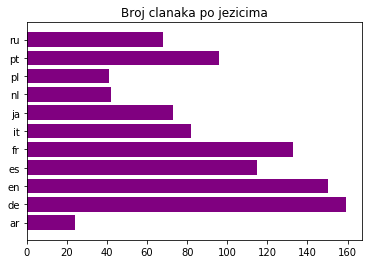

In [22]:
plt.title('Broj clanaka po jezicima')
plt.barh(np.arange(0, number_of_classes), np.bincount(dataset.target), color='purple')
plt.yticks(np.arange(0, number_of_classes), dataset.target_names)
plt.show()

Analiziramo skup tekstova sa kojima radimo.

In [23]:
data = dataset.data

In [24]:
type(data)

list

In [25]:
len(data)

983

In [26]:
data[3]

b"I cosiddetti WikiReader (pubblicazioni su carta con selezioni di voci) sono stati lanciati dalla Wikipedia tedesca nel tardo febbraio 2004 con il primo WikiReader sulla Svezia di Thomas Karcher. Hanno fatto seguito altri WikiReader preparati nel formato PDF o con le versioni stampate in preparazione per la vendita. L'esempio tedesco \xc3\xa8 stato ripreso altrove per cui sono nati altri progetti WikiReader ad opera degli utenti cinesi, inglesi, francesi e polacchi. Wikipress[43] ha messo in vendita un libro in brossura dell'edizione 2005-2006 comprensivo di un DVD.\n"

Delimo podatke na skup za treniranje i skup za testiranje. 

In [27]:
data_train, data_test, y_train, y_test = model_selection.train_test_split(dataset.data, dataset.target, test_size=0.33, stratify= dataset.target)

U zadatku prepoznavanja jezika su se dobro pokazali n-grami karaktera tj. sekvence nekoliko uzastopnih karaktera. Na primer, svi unigrami (1-grami) reči "abcde" su "a", "b", "c", "d", "e", svi bigrami (2-grami) iste reči su "ab", "bc", "cd", "de", dok su svi 3-grami "abc", "bcd", "cde".  Njih možemo lako generisati korišćenjem funkcija za ekstrakciju tekstualnih atributa biblioteke `scikit-learn`.

Kreiramo vektorajzer u kome naglašavamo da ćemo koristiti unigrame, bigrame i trigrame karaktera (parametri `ngram_range` i `analyzer`). Takođe, naglašavamo da nećemo koristiti inverznu frekvenciju dokumenata prilikom izračunavanja vrednosti već da ćemo se osloniti na frekvencije pojavljivanja.

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char', use_idf=False, min_df=5)

In [29]:
vectorizer.fit(data_train)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=False, vocabulary=None)

Analiziramo prisutne n-grame.

In [30]:
feature_names = vectorizer.get_feature_names()

In [31]:
len(feature_names)

9408

In [32]:
feature_names[3000:3020]

['gep',
 'ger',
 'ges',
 'get',
 'gev',
 'gew',
 'gez',
 'gf',
 'gfd',
 'gg',
 'gge',
 'ggi',
 'gh',
 'gh ',
 'ghe',
 'ght',
 'gi',
 'gia',
 'gib',
 'gic']

Transformišemo tekstove koji se nalaze u skupovima za treniranje i testiranje tako da imaju odgovarajuće n-gramske profile. 

In [33]:
X_train = vectorizer.transform(data_train)
X_test = vectorizer.transform(data_test)

In [34]:
X_train.shape

(658, 9408)

In [35]:
X_test.shape

(325, 9408)

Kreiramo model.

Klasifikator koji ćemo koristiti je linearni SVM. Ukoliko se navede parametar `multi_class` naglašava se da ga treba koristiti kao višeklasni klasifikator. Vrednost `ovr` se odnosi na `OneVsRest` ponašanje, dok `OneVsOne` nije direktno podržano.

In [36]:
svm_classifier = svm.LinearSVC(multi_class='ovr', loss='hinge')

In [37]:
svm_classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

Evaluiramo model.

In [38]:
y_predicted = svm_classifier.predict(X_test)

In [39]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        44
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        32
          10       1.00      1.00      1.00        22

    accuracy                           1.00       325
   macro avg       1.00      1.00      1.00       325
weighted avg       1.00      1.00      1.00       325



In [40]:
print(metrics.confusion_matrix(y_test, y_predicted))

[[ 8  0  0  0  0  0  0  0  0  0  0]
 [ 0 53  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  0  0]
 [ 0  0  0  0  0 27  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0  0 32  0]
 [ 0  0  0  0  0  0  0  0  0  0 22]]


In [41]:
test_sentences = [
    'This is a language detection test.',
    'Ceci est un test de d\xe9tection de la langue.',
    'Dies ist ein Test, um die Sprache zu erkennen.',
]

In [42]:
language_codes = svm_classifier.predict(vectorizer.transform(test_sentences))
language_codes

array([2, 4, 1])

In [43]:
language_names = np.array(dataset.target_names)[language_codes]
language_names

array(['en', 'fr', 'de'], dtype='<U2')

In [44]:
for test_sentence, language_name in zip(test_sentences, language_names):
    print(test_sentence, ' -- ', language_name)

This is a language detection test.  --  en
Ceci est un test de détection de la langue.  --  fr
Dies ist ein Test, um die Sprache zu erkennen.  --  de


<link href="//maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css" rel="stylesheet">
<p style="text-align: right; color: blue"> 
    Oh, it is  
    <i class="fa fa-snowflake-o"></i>
    snowing!
</p>